<a href="https://colab.research.google.com/github/gilsonauerswald/Bioinformatic_Projects/blob/main/Single_cell_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Single Cell Analysis**


In this tutorial, we will be analyzing the a dataset of Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500.

The example raw data can be found here (https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)



First, install and Load Required packages

In [ ]:
install.packages('Seurat')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages('SeuratData')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘SeuratData’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [ ]:
install.packages('ggplot2')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages('patchwork')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages('dplyr')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(Seurat)
#library(SeuratData)
library(ggplot2)
library(patchwork)
library(dplyr)

First, Read10X() function reads in the output of the cellranger pipeline from 10X, returning a unique molecular identified (UMI) count matrix. The values in this matrix represent the number of molecules for each feature (i.e. gene; row) that are detected in each cell (column).

In [ ]:
# Create a directory for extraction
dir.create("/content/pbmc3k")

# Extract the tar.gz file
system("tar -xzvf /content/pbmc3k_filtered_gene_bc_matrices.tar.gz -C /content/pbmc3k")

Warning message in dir.create("/content/pbmc3k"):
“'/content/pbmc3k' already exists”


In [ ]:
library(Seurat)

#Load Data
data_dir <- "/content/pbmc3k/filtered_gene_bc_matrices/hg19"
pbmc.data <- Read10X(data.dir = data_dir)

# Create a Seurat object
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "PBMC3K", min.cells = 3, min.features = 200)

# Inspect the object
pbmc


ERROR: Error in library(Seurat): there is no package called ‘Seurat’


View matrix data

In [ ]:
# Lets view a few genes in the first 10 cells
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]

ERROR: Error: object 'pbmc.data' not found


view metadata

In [ ]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACATACAACCAC-1,PBMC3K,2419,779
AAACATTGAGCTAC-1,PBMC3K,4903,1352
AAACATTGATCAGC-1,PBMC3K,3147,1129
AAACCGTGCTTCCG-1,PBMC3K,2639,960
AAACCGTGTATGCG-1,PBMC3K,980,521


**QC and selection of good quality cells**

**A few QC metrics commonly used:**
1. The number of unique genes detected in each cell.

- Low-quality cells or empty droplets will often have very few genes
Cell doublets or multiplets may exhibit an aberrantly high gene count
Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes)

2. The percentage of reads that map to the mitochondrial genome
- Low-quality / dying cells often exhibit extensive mitochondrial contamination

We calculate mitochondrial QC metrics with the PercentageFeatureSet() function, which calculates the percentage of counts originating from a set of features
We use the set of all genes starting with MT- as a set of mitochondrial genes

In [ ]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [ ]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,PBMC3K,2419,779,3.0177759
AAACATTGAGCTAC-1,PBMC3K,4903,1352,3.7935958
AAACATTGATCAGC-1,PBMC3K,3147,1129,0.8897363
AAACCGTGCTTCCG-1,PBMC3K,2639,960,1.7430845
AAACCGTGTATGCG-1,PBMC3K,980,521,1.2244898


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


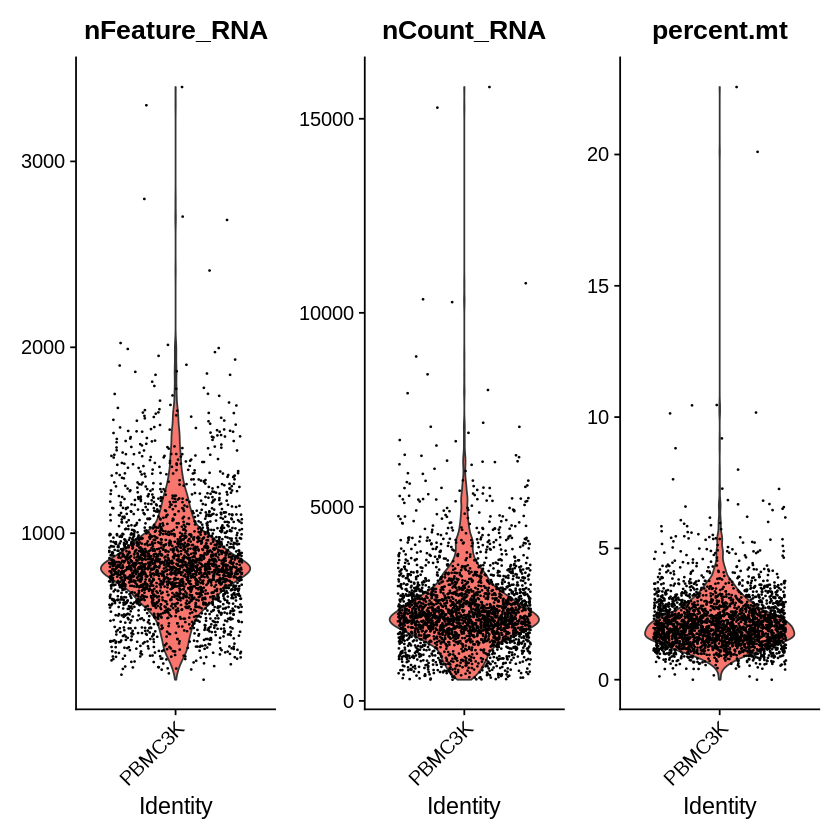

In [ ]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

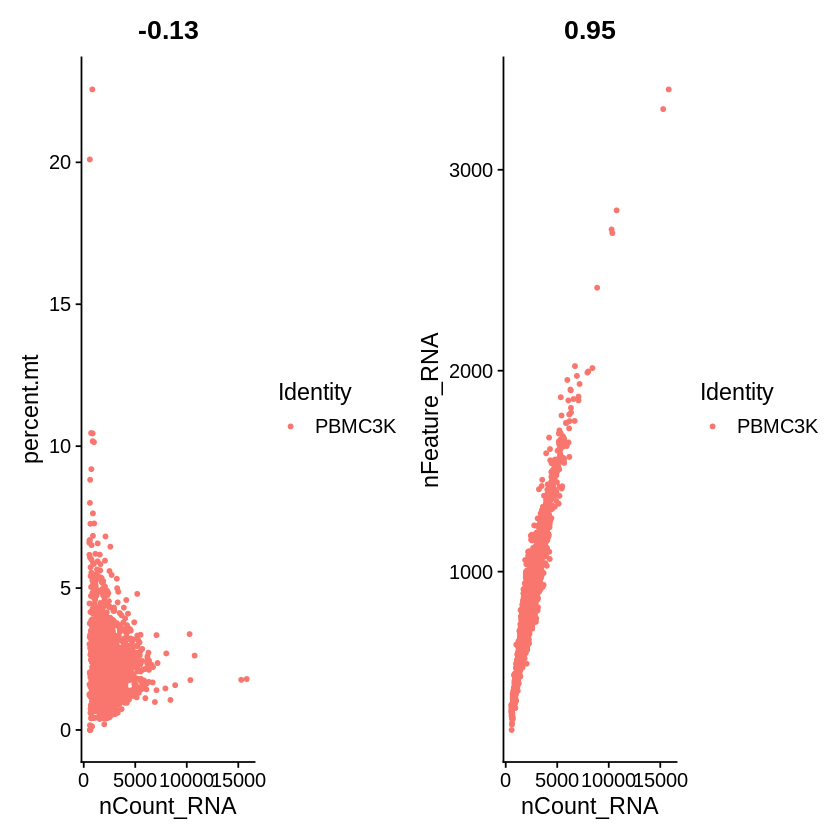

In [ ]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

**Qality control filters**

We filter cells that have unique feature counts over 2,500 or less than 200
We filter cells that have >5% mitochondrial counts

Remove empty/broken cells (with high mitrochondrial content) and doublets/multiplets (by removing high RNA features >2000/2500)

In [ ]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

**Normalizing the data**

After removing unwanted cells from the dataset, the next step is to normalize the data.

By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result.

In [ ]:
#Normalize data
pbmc_norm <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
#or
#pbmc_norm <- NormalizeData(pbmc)

Normalizing layer: counts



**Identify Highly variable features (feature selection)**

Now, we will identify a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). These genes in downstream analysis helps to highlight biological signal in single-cell datasets.

For this purpose, we can use FindVariableFeatures() function. By default, we return 2,000 features per dataset. These will be used in downstream analysis, like PCA.

In [ ]:
pbmc_hv <- FindVariableFeatures(pbmc_norm, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc_hv), 10)

Finding variable features for layer counts



Visualize top features

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


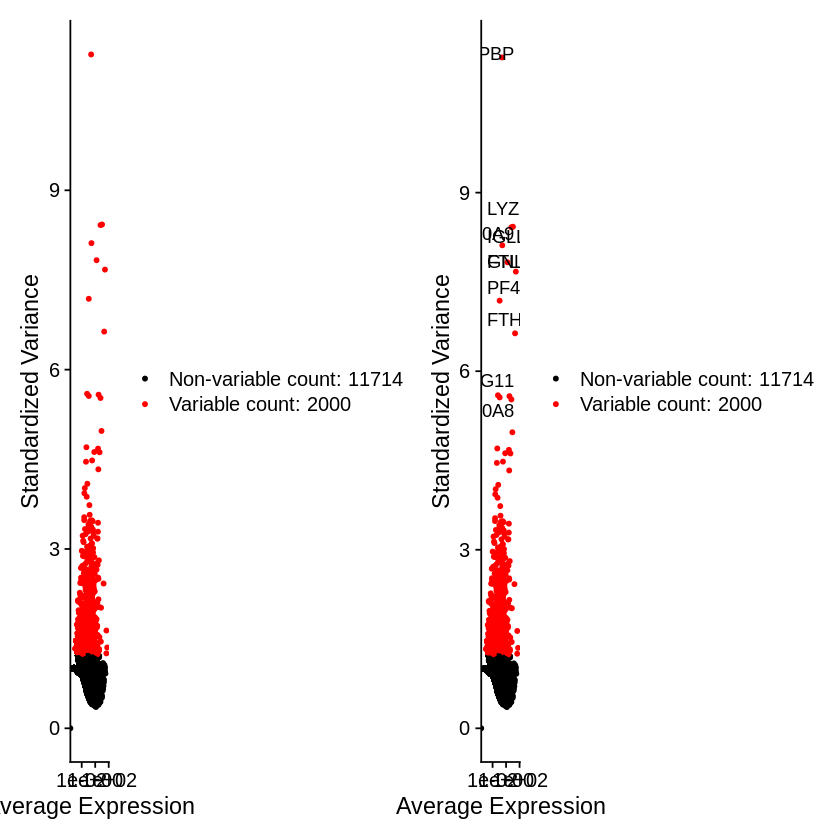

In [ ]:
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc_hv)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

**Scaling the data**

Now, we will apply ‘scaling’ that is a standard pre-processing step prior to dimensional reduction techniques like PCA using ScaleData() function:

It will Shifts the expression of each gene, so that the mean expression across cells is 0 Scales the expression of each gene, so that the variance across cells is 1.

This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate

In [ ]:
#scale data
all.genes <- rownames(pbmc_hv)
pbmc_scaled <- ScaleData(pbmc_hv, features = all.genes)

Centering and scaling data matrix



**Linear dimensional Reduction**

Next we will perform PCA on the scaled data. By default, only the previously determined variable features are used as input

In [ ]:
#perform PCA
pbmc_pca <- RunPCA(pbmc_scaled, features = VariableFeatures(object = pbmc_scaled))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

In [ ]:
# Examine and visualize PCA results a few different ways
print(pbmc_pca[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


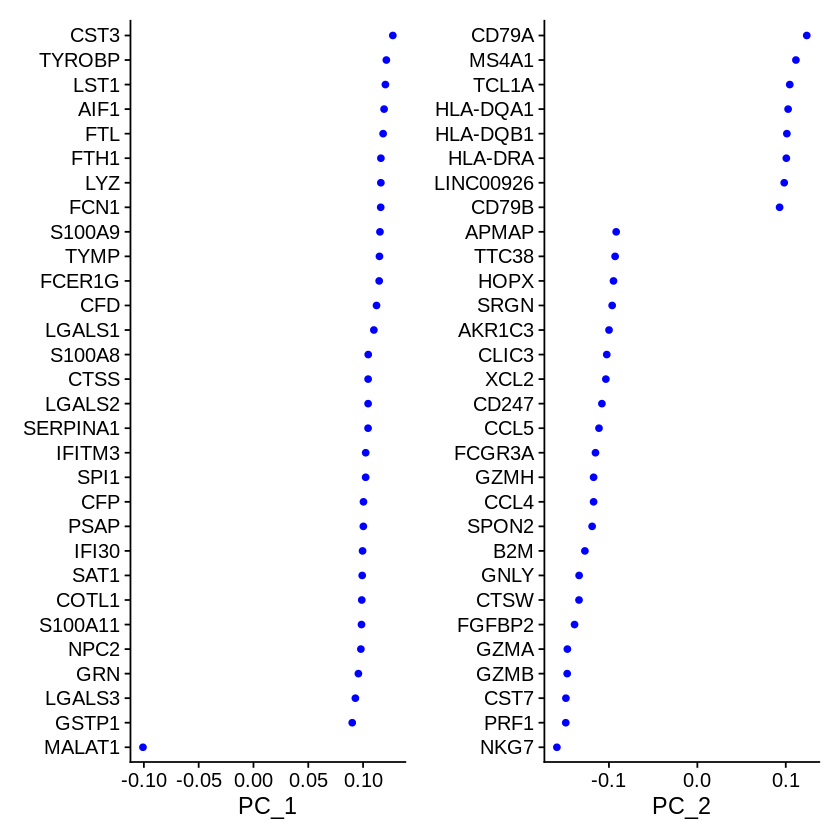

In [ ]:
VizDimLoadings(pbmc_pca, dims = 1:2, reduction = "pca")

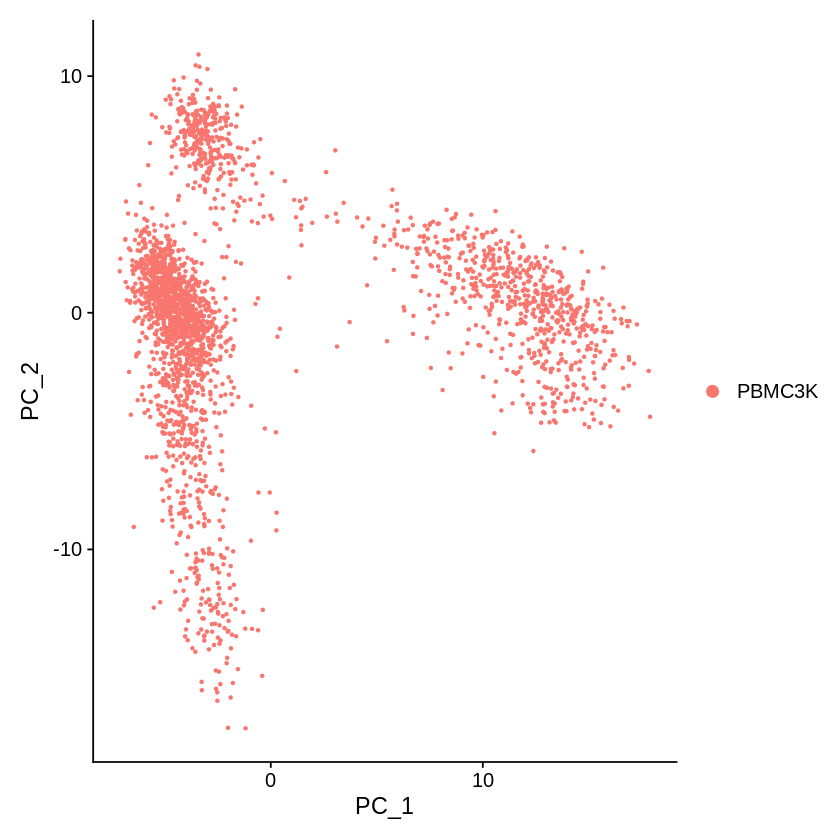

In [ ]:
#PCA scatterplot
DimPlot(pbmc_pca, reduction = "pca")

**DimHeatmap**

DimHeatmap() allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses.

Both cells and features are ordered according to their PCA scores.

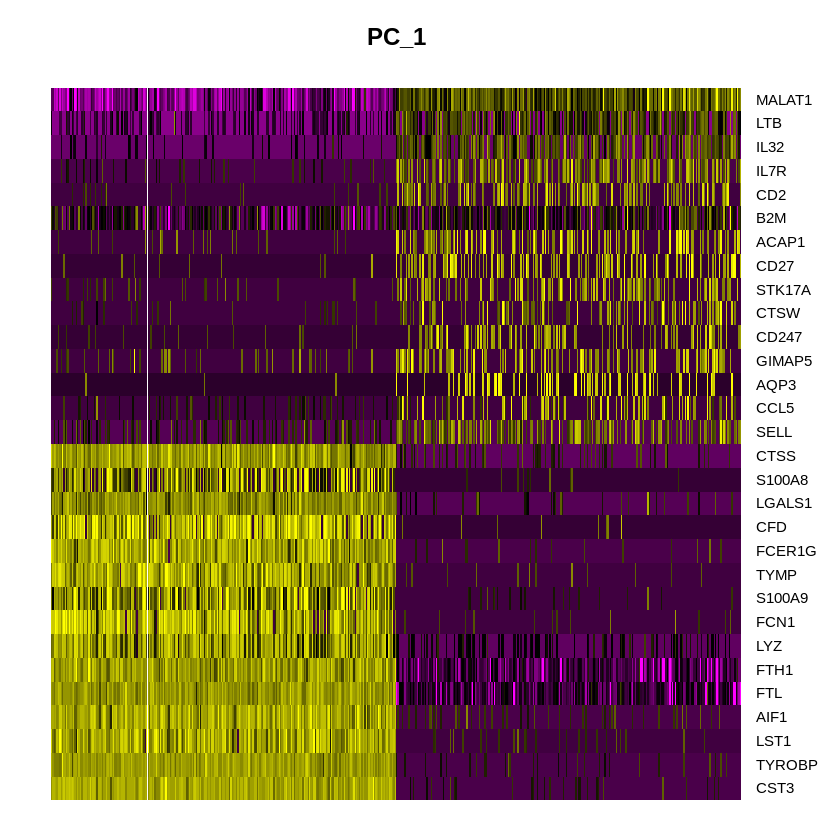

In [ ]:
DimHeatmap(pbmc_pca, dims = 1, cells = 500, balanced = TRUE)

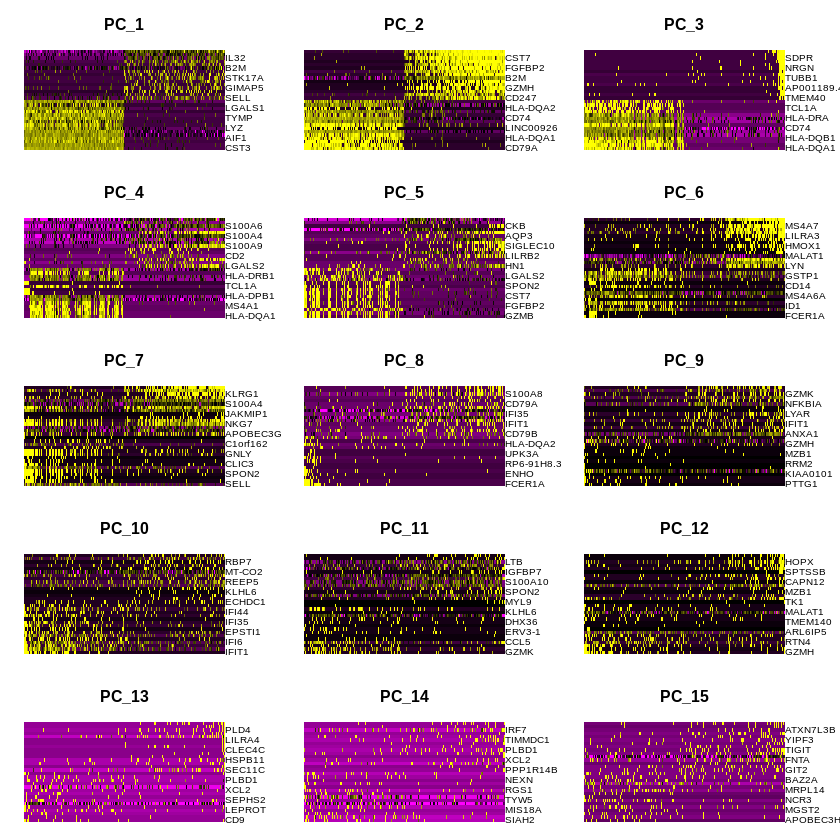

In [ ]:
DimHeatmap(pbmc_pca, dims = 1:15, cells = 500, balanced = TRUE)

**Determine the ‘dimensionality’ of the dataset**

To overcome the extensive technical noise in any single feature for scRNA-seq data, Seurat clusters cells based on their PCA scores, with each PC essentially representing a ‘metafeature’ that combines information across a correlated feature set.

The top principal components therefore represent a robust compression of the dataset. However, how many components should we choose to include? 10? 20? 100?

In Macosko et al, we implemented a resampling test inspired by the JackStraw procedure. We randomly permute a subset of the data (1% by default) and rerun PCA, constructing a ‘null distribution’ of feature scores, and repeat this procedure. We identify ‘significant’ PCs as those who have a strong enrichment of low p-value features.

**NOTE:** This process can take a long time for big datasets, comment out for expediency. More

approximate techniques such as those implemented in ElbowPlot() can be used to reduce


In [ ]:
# computation time
pbmc_p <- JackStraw(pbmc_pca, num.replicate = 100)


In [ ]:
pbmc_score <- ScoreJackStraw(pbmc_p, dims = 1:20)

**JackStrawPlot**

The JackStrawPlot() function provides a visualization tool for comparing the distribution of p-values for each PC with a uniform distribution (dashed line).

‘Significant’ PCs will show a strong enrichment of features with low p-values (solid curve above the dashed line).

Warning message:
“Removed 32535 rows containing missing values or values outside the scale range
(`geom_point()`).”


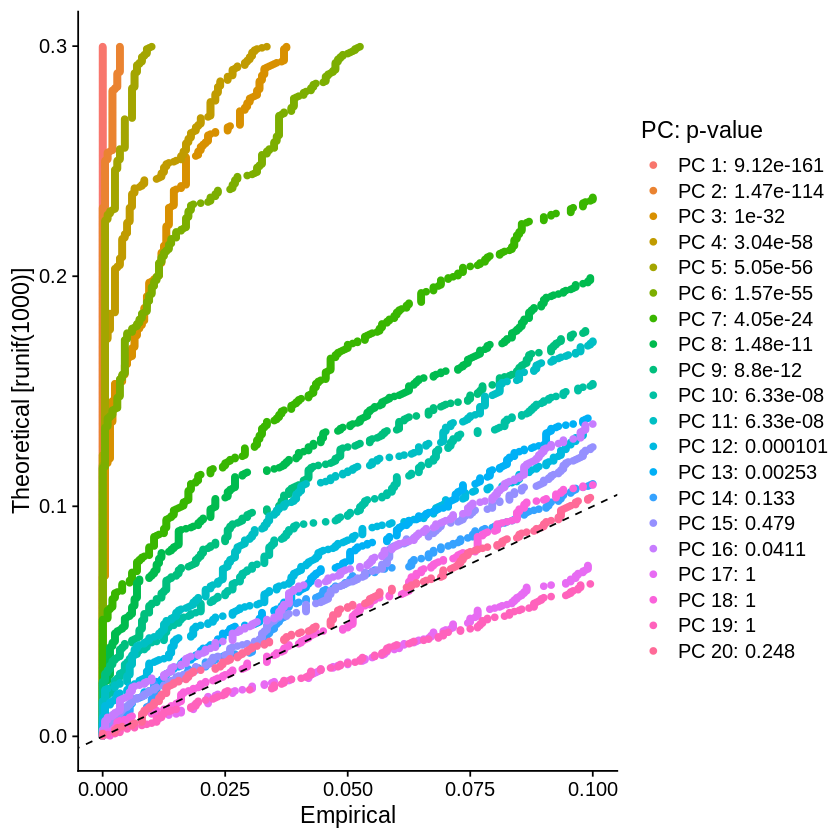

In [ ]:
JackStrawPlot(pbmc_score, dims = 1:20)

 In this case it appears that there is a sharp drop-off in significance after the first 10-12 PCs.

**Elbow plot**

An alternative heuristic method generates an ‘Elbow plot’: a ranking of principle components based on the percentage of variance explained by each one (ElbowPlot() function).

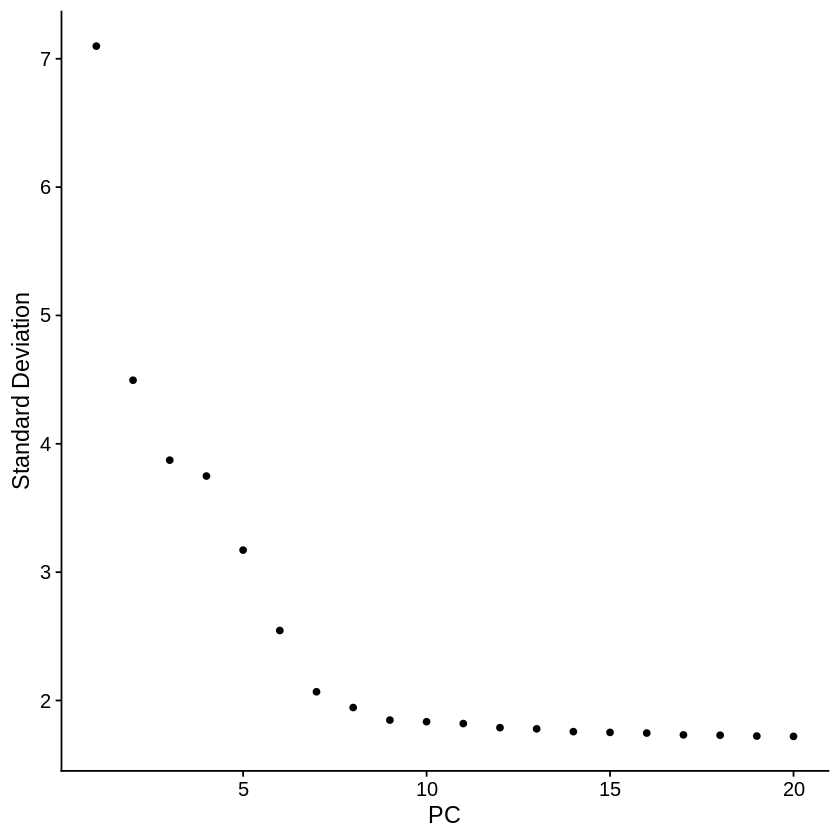

In [ ]:
ElbowPlot(pbmc_score)

In this example, we can observe an ‘elbow’ around PC9-10, suggesting that the majority of true signal is captured in the first 10 PCs.

**Clustering of cells**

Seurat v3 applies a graph-based clustering approach, building upon initial strategies in (Macosko et al). Importantly, the distance metric which drives the clustering analysis (based on previously identified PCs) remains the same. However, in this approach of clustering embed cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar feature expression patterns, and then attempt to partition this graph into highly interconnected ‘quasi-cliques’ or ‘communities’.

As in PhenoGraph, here, a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). This step is performed using the FindNeighbors() function, and takes as input the previously defined dimensionality of the dataset (first 10 PCs).

To cluster the cells,  next, we will apply modularity optimization techniques such as the Louvain algorithm (default) or SLM [SLM, Blondel et al., Journal of Statistical Mechanics], to iteratively group cells together, with the goal of optimizing the standard modularity function.

The FindClusters() function implements this procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters. We find that setting this parameter between 0.4-1.2 typically returns good results for single-cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters can be found using the Idents() function.

In [ ]:
pbmc_nn <- FindNeighbors(pbmc_score, dims = 1:10) ## taken first 10 pca components


Computing nearest neighbor graph

Computing SNN



In [ ]:
#find clusters
pbmc_cluster <- FindClusters(pbmc_nn, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


In [ ]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
          PBMC3K           PBMC3K           PBMC3K           PBMC3K 
AAACCGTGTATGCG-1 
          PBMC3K 
Levels: PBMC3K

**Perform non-linear dimensional reduction (UMAP/tSNE)**
Seurat allows several non-linear dimensional reduction techniques, such as tSNE and UMAP, to visualize and explore these datasets.

 The goal of these algorithms is to learn the underlying manifold of the data in order to place similar cells together in low-dimensional space. Cells within the graph-based clusters determined above should co-localize on these dimension reduction plots

**UMAP**

In [ ]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages =
# 'umap-learn')
pbmc_umap <- RunUMAP(pbmc_cluster, dims = 1:10)

10:03:56 UMAP embedding parameters a = 0.9922 b = 1.112

10:03:56 Read 2638 rows and found 10 numeric columns

10:03:56 Using Annoy for neighbor search, n_neighbors = 30

10:03:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:03:56 Writing NN index file to temp file /tmp/RtmpSL4hzg/file14b79195dfd

10:03:56 Searching Annoy index using 1 thread, search_k = 3000

10:03:58 Annoy recall = 100%

10:03:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:03:59 Initializing from normalized Laplacian + noise (using RSpectra)

10:03:59 Commencing optimization for 500 epochs, with 105124 positive edges

10:04:03 Optimization finished



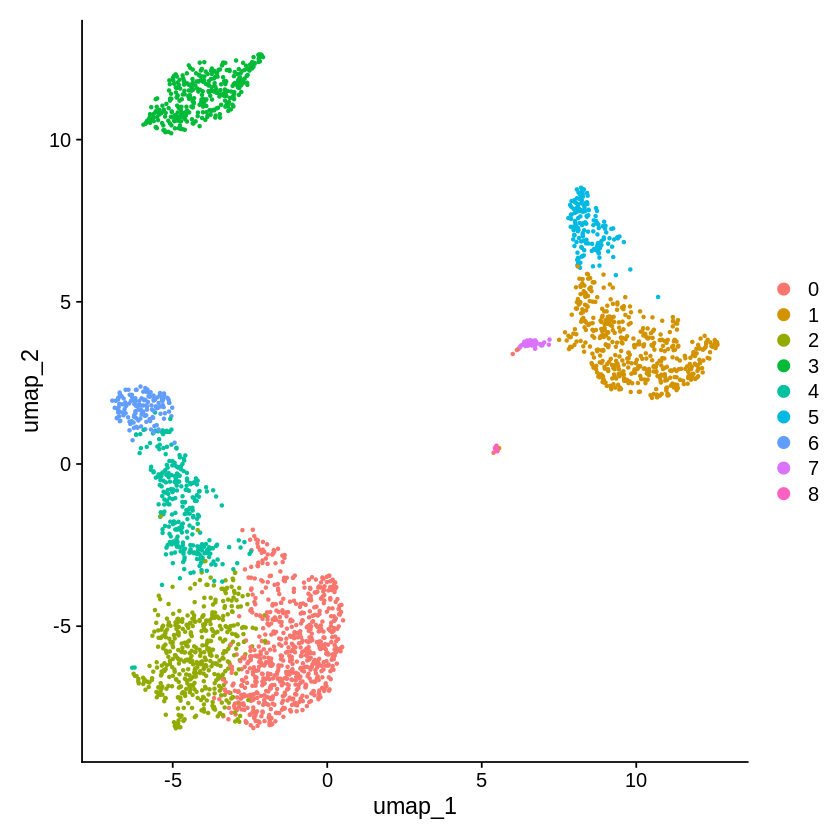

In [ ]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(pbmc_umap, reduction = "umap")

Now, save the object at this point so that it can easily be loaded back in without having to rerun the computationally intensive steps performed above

In [ ]:
#save data or object
saveRDS(pbmc_umap, file = "pbmc_umap.rds")

**Finding differentially expressed features (cluster biomarkers)**

Seurat help you find markers that define clusters via differential expression.

By default, it identifies positive and negative markers of a single cluster (specified in ident.1), compared to all other cells.

`FindAllMarkers()` automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The `min.pct` argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the `thresh.test` argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory.

As another option to speed up these computations, `max.cells.per.ident` can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significant and the most highly differentially expressed features will likely still rise to the top.

**find all markers of cluster 2**


In [ ]:
cluster2.markers <- FindMarkers(pbmc_umap, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,2.593535e-91,1.3221171,0.949,0.466,3.556774e-87
LTB,7.994465e-87,1.3450377,0.981,0.644,1.096361e-82
CD3D,3.922451e-70,1.0562099,0.922,0.433,5.379250e-66
IL7R,1.130870e-66,1.4256944,0.748,0.327,1.550876e-62
LDHB,4.082189e-65,0.9765875,0.953,0.614,5.598314e-61


In [ ]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc_umap, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,2.150929e-209,6.832372,0.975,0.039,2.949784e-205
IFITM3,6.103366e-199,6.181000,0.975,0.048,8.370156e-195
CFD,8.891428e-198,6.052575,0.938,0.037,1.219370e-193
CD68,2.374425e-194,5.493138,0.926,0.035,3.256286e-190
RP11-290F20.3,9.308287e-191,6.335402,0.840,0.016,1.276538e-186


**Find markers for every cluster compared to all remaining cells**

In [ ]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc_umap, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.167632e-83,2.369020,0.435,0.108,1.601290e-79,0,CCR7
3.284150e-49,2.096128,0.333,0.103,4.503883e-45,0,LEF1
3.098695e-139,7.284513,0.300,0.004,4.249550e-135,1,FOLR3
1.625903e-121,6.741401,0.277,0.006,2.229763e-117,1,S100A12
2.610017e-59,2.108140,0.424,0.111,3.579377e-55,2,AQP3
1.941642e-35,1.901907,0.267,0.069,2.662768e-31,2,CD40LG
2.397625e-272,7.379757,0.564,0.009,3.288103e-268,3,LINC00926
2.745016e-237,7.135051,0.488,0.007,3.764515e-233,3,VPREB3
4.932509e-169,4.366254,0.595,0.056,6.764443e-165,4,GZMK


Seurat has several tests for differential expression which can be set with the test.use parameter (see our DE vignette for details). For example, the ROC test returns the ‘classification power’ for any individual marker

In [ ]:
cluster0.markers <- FindMarkers(pbmc_umap, ident.1 = 2, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

In [ ]:
head(cluster0.markers,5)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LTB,0.786,0.8892106,0.572,1.3450377,0.981,0.644
IL32,0.784,0.8424760,0.568,1.3221171,0.949,0.466
LDHB,0.746,0.6125566,0.492,0.9765875,0.953,0.614
CD3D,0.745,0.6487310,0.490,1.0562099,0.922,0.433
IL7R,0.724,0.8162520,0.448,1.4256944,0.748,0.327


***Visualizing marker expression ***

`VlnPlot()` (shows expression probability distributions across clusters), and `FeaturePlot()` (visualizes feature expression on a PCA plot) are our most commonly used visualizations.

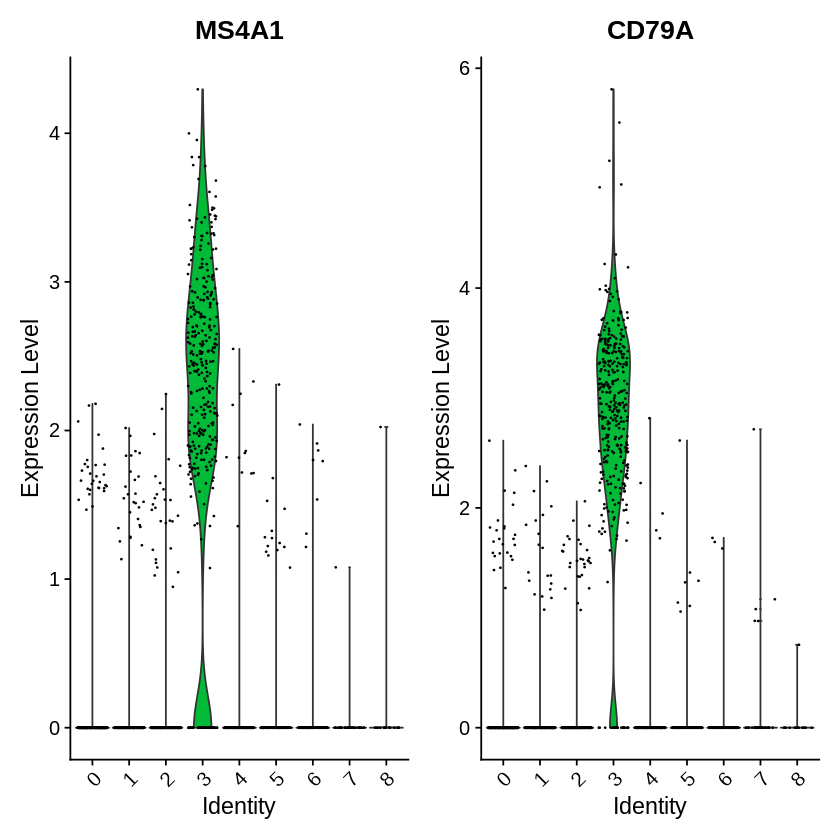

In [ ]:
VlnPlot(pbmc_umap, features = c("MS4A1", "CD79A"))

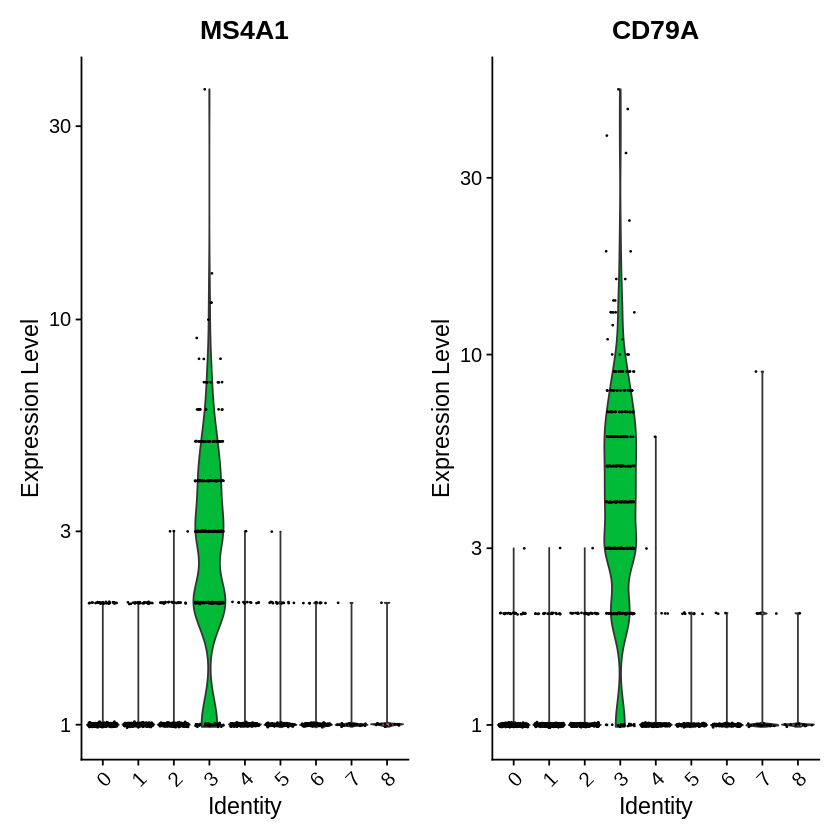

In [ ]:
# you can plot raw counts as well
VlnPlot(pbmc_umap, features = c("MS4A1", "CD79A"), slot = "counts", log = TRUE)

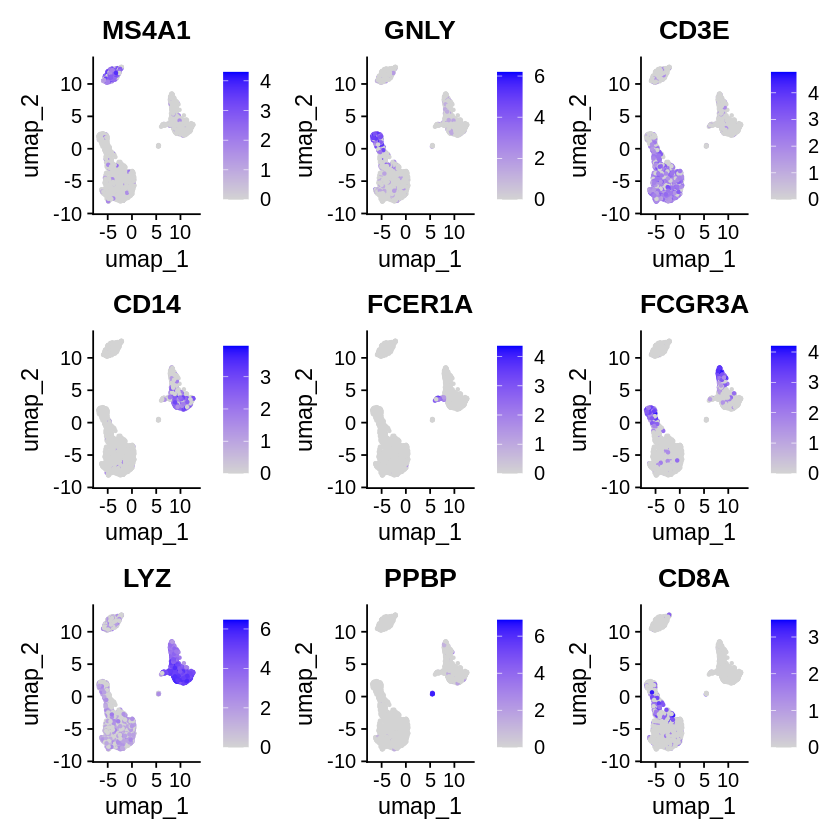

In [ ]:
#feature plot
FeaturePlot(pbmc_umap, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",
    "CD8A"))

**Heatmap**

`DoHeatmap() `generates an expression heatmap for given cells and features. In this case, we are plotting the top 20 markers (or all markers if less than 20) for each cluster.

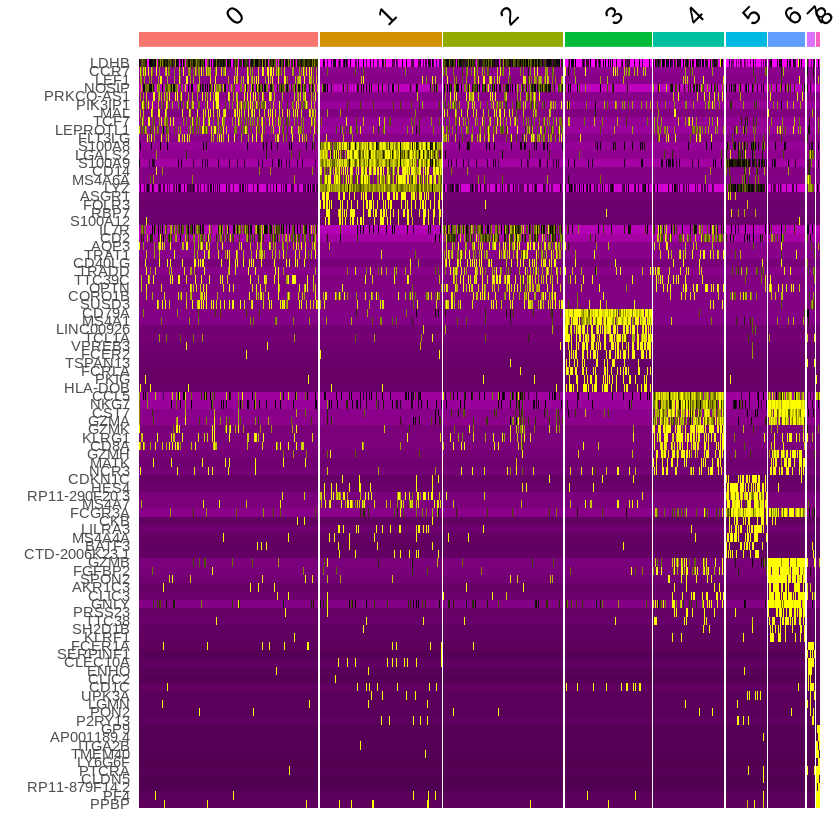

In [ ]:
#heatmap for top markers
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc_umap, features = top10$gene) + NoLegend()

**Assigning cell type identity to clusters**

we can use canonical markers to easily match the unbiased clustering to known cell types

In [ ]:
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc_umap)

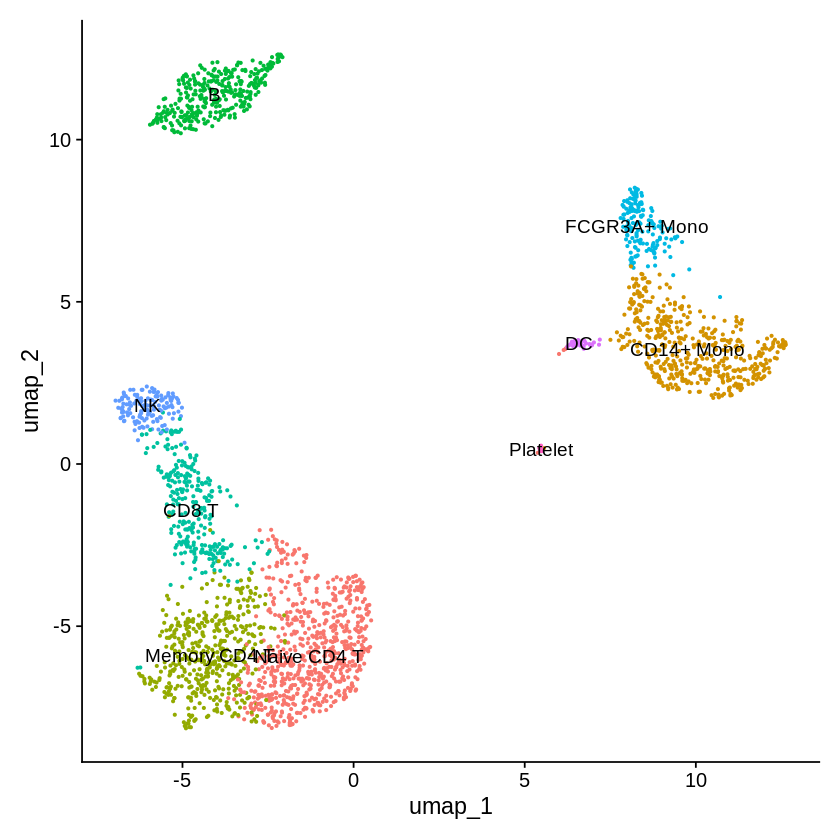

In [ ]:
#rename clusters with cell types
pbmc_umap_new <- RenameIdents(pbmc_umap, new.cluster.ids)

#plot dimplot with cell type
DimPlot(pbmc_umap_new, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()


In [ ]:
#save object based on cell type
saveRDS(pbmc_umap_new, file = "pbmc3k_final_umap_cells.rds")